# Car Company APR and Revenue A/B Test

###### by Sam Brady 

### Import Data and Libraries

In [39]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
car_company = pd.read_csv('car_company_apr.csv', header=0, index_col=False, usecols=list(range(0, 7, 1)))

In [5]:
car_company

,app_id,fico,apr_test_group,apr,converted to sale,vehicle margin,finance margin
0,1,700,control,4.0%,False,NaN,NaN
1,2,700,test,3.0%,False,NaN,NaN
2,3,700,test,3.0%,False,NaN,NaN
3,4,700,control,4.0%,False,NaN,NaN
4,5,700,control,4.0%,True,1000.0,600.0
...,...,...,...,...,...,...,...
19995,19996,600,test,4.4%,True,1000.0,400.0
19996,19997,600,test,4.4%,False,NaN,NaN
19997,19998,600,test,4.4%,False,NaN,NaN
19998,19999,600,control,5.4%,False,NaN,NaN


### EDA

In [6]:
car_company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   app_id             20000 non-null  int64  
 1   fico               20000 non-null  int64  
 2   apr_test_group     20000 non-null  object 
 3   apr                20000 non-null  object 
 4   converted to sale  20000 non-null  bool   
 5   vehicle margin     5021 non-null   float64
 6   finance margin     5021 non-null   float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 957.2+ KB


In [7]:
car_company.dtypes

app_id                 int64
fico                   int64
apr_test_group        object
apr                   object
converted to sale       bool
vehicle margin       float64
finance margin       float64
dtype: object

In [8]:
car_company.isna().sum()

app_id                   0
fico                     0
apr_test_group           0
apr                      0
converted to sale        0
vehicle margin       14979
finance margin       14979
dtype: int64

In [9]:
pd.set_option('precision', 4)
car_company.describe()

,app_id,fico,vehicle margin,finance margin
count,20000.000,20000.0000,5021.0,5021.0000
mean,10000.500,649.9950,1000.0,488.7771
std,5773.647,50.0012,0.0,127.3700
min,1.000,600.0000,1000.0,350.0000
25%,5000.750,600.0000,1000.0,350.0000
50%,10000.500,600.0000,1000.0,400.0000
75%,15000.250,700.0000,1000.0,600.0000
max,20000.000,700.0000,1000.0,650.0000


In [10]:
car_company.describe(include=[np.object])

,apr_test_group,apr
count,20000,20000
unique,2,4
top,control,5.4%
freq,10021,5095


In [11]:
profile = ProfileReport(car_company, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Chart Controls

In [12]:
# set the color theme and chart controls for plotting
# car_company color scheme
car_company_blue = '#00A2D3'
car_company_lightblue = '#47B7DC'
car_company_gold = '#F9B732'
car_company_lightgrey = '#5E5E5E'
car_company_grey = '#343C3A'
car_company_test_palette = {'control':car_company_lightblue, 'test':car_company_gold}
car_company_fico_palette = {600:car_company_lightblue, 700:car_company_gold}
car_company_apr_palette = {3.0:car_company_gold, 4.0:car_company_lightblue, 4.4:car_company_gold, 5.4:car_company_lightblue, 
                       6.4:car_company_lightgrey , 5.0:car_company_lightgrey }
car_company_heatmap = [car_company_blue, car_company_lightblue, car_company_gold, car_company_lightgrey ]
car_company_list = ['#47B7DC','#F9B732', '#47B7DC','#F9B732' , '#47B7DC','#F9B732'  ]
outer_list = [ '#00A2D3','#47B7DC',]
inner_list = ['#F9B732' , '#5E5E5E', '#F9B732','#5E5E5E']

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = car_company_lightgrey  

# remove some borders    
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False


### Distributions

In [13]:
# split data into test and control groups
control = car_company[car_company['apr_test_group'] == 'control']
test = car_company[car_company['apr_test_group'] == 'test']

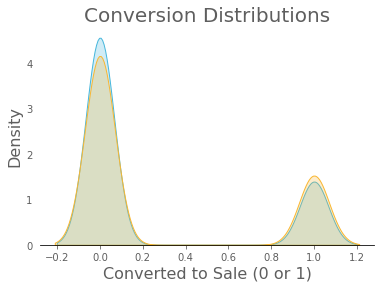

In [14]:
# compare distributions of factors between groups 
sns.kdeplot(control['converted to sale'], label='control', shade = True, color = car_company_lightblue )
sns.kdeplot(test['converted to sale'], label='test', shade = True, color = car_company_gold )
plt.title('Conversion Distributions', fontsize = 20)
plt.xlabel('Converted to Sale (0 or 1)', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.show()

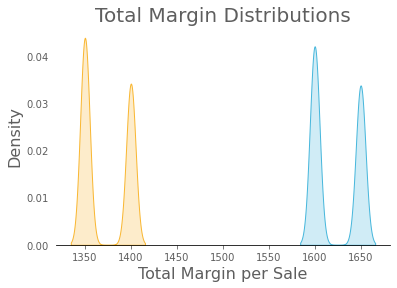

In [15]:
# compare distributions of factors between groups 
sns.kdeplot(control['vehicle margin'] + control['finance margin'] , label='control', shade = True, 
            color = car_company_lightblue )
sns.kdeplot(test['vehicle margin'] + test['finance margin'] , label='test', shade = True, 
            color = car_company_gold )
plt.title('Total Margin Distributions', fontsize = 20)
plt.xlabel('Total Margin per Sale', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.show()

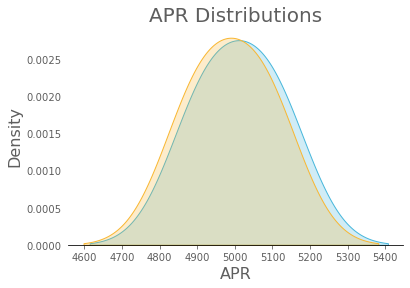

In [16]:
# compare distributions of factors between groups 
sns.kdeplot(control['apr'].value_counts() , label='control', shade = True, color = car_company_lightblue )
sns.kdeplot(test['apr'].value_counts()  , label='test', shade = True, color = car_company_gold )
plt.title('APR Distributions', fontsize = 20)
plt.xlabel('APR', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.show()

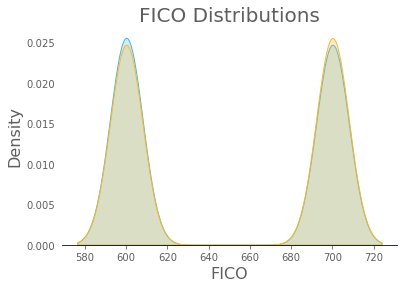

In [17]:
# compare distributions of factors between groups 
sns.kdeplot(control['fico'] , label='control', shade = True, color = car_company_lightblue )
sns.kdeplot(test['fico'] , label='test', shade = True, color = car_company_gold )
plt.title('FICO Distributions', fontsize = 20)
plt.xlabel('FICO', fontsize=16);
plt.ylabel('Density', fontsize=16)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)
plt.show()

### Data Subsetting and Feature Engineering

In [18]:
# convert apr to float values and remove %
car_company['apr'] = car_company['apr'].str.rstrip('%').astype('float')

In [19]:
# add in total margin column
car_company['total_margin'] = car_company['vehicle margin'] + car_company['finance margin'] 

In [20]:
# group and subset counts of apps and sales
fico_apr = car_company.groupby(['apr_test_group', 'fico', 'apr']).count()
fico_apr = pd.DataFrame(fico_apr.to_records())
fico_apr = fico_apr.rename(columns={'app_id':'total_apps', 'vehicle margin':'num_sales'})
fico_apr = fico_apr.drop(['converted to sale', 'finance margin', 'total_margin'], axis = 1)
fico_apr['num_no_sale'] = fico_apr['total_apps'] - fico_apr['num_sales'] 
fico_apr

,apr_test_group,fico,apr,total_apps,num_sales,num_no_sale
0,control,600,5.4,5095,1044,4051
1,control,700,4.0,4926,1300,3626
2,test,600,4.4,4906,1172,3734
3,test,700,3.0,5073,1505,3568


In [21]:
# group and subset totals of margins, add in per sale
summary_margin = car_company.groupby(['apr_test_group', 'fico', 'apr']).sum()
summary_margin = pd.DataFrame(summary_margin.to_records())
summary_margin = summary_margin.rename(columns={'converted to sale':'num_sales'})
summary_margin = summary_margin.drop(['app_id'], axis = 1)
summary_margin['total_margin_per_sale'] = summary_margin['total_margin'] / summary_margin['num_sales']
summary_margin['vehicle_margin_per_sale'] = summary_margin['vehicle margin'] / summary_margin['num_sales']
summary_margin['finance_margin_per_sale'] = summary_margin['finance margin'] / summary_margin['num_sales']
summary_margin

,apr_test_group,fico,apr,num_sales,vehicle margin,finance margin,total_margin,total_margin_per_sale,vehicle_margin_per_sale,finance_margin_per_sale
0,control,600,5.4,1044,1044000.0,678600.0,1722600.0,1650.0,1000.0,650.0
1,control,700,4.0,1300,1300000.0,780000.0,2080000.0,1600.0,1000.0,600.0
2,test,600,4.4,1172,1172000.0,468800.0,1640800.0,1400.0,1000.0,400.0
3,test,700,3.0,1505,1505000.0,526750.0,2031750.0,1350.0,1000.0,350.0


In [22]:
# add in conversion rate per group
conversion = car_company.groupby(['apr_test_group', 'fico', 'apr']).agg([np.mean, np.std]).drop(['app_id', 
                            'vehicle margin', 'finance margin', 'total_margin'], axis = 1)
conversion = pd.DataFrame(conversion.to_records())
conversion.columns = ['apr_test_group', 'fico', 'apr', 'conversion_rate', 'conversion_std']
conversion

,apr_test_group,fico,apr,conversion_rate,conversion_std
0,control,600,5.4,0.2049,0.4037
1,control,700,4.0,0.2639,0.4408
2,test,600,4.4,0.2389,0.4264
3,test,700,3.0,0.2967,0.4568


In [23]:
# combine all subsets into a summary df, add in margins per app
summary = fico_apr.merge(summary_margin, how='inner', on=['apr_test_group', 'fico', 'apr', 'num_sales'])
summary = conversion.merge(summary, how='inner', on=['apr_test_group', 'fico', 'apr'])
summary['total_margin_per_app'] =  summary['total_margin'] / summary['total_apps'] 
summary['vehicle_margin_per_app'] =  summary['vehicle margin'] / summary['total_apps'] 
summary['finance_margin_per_app'] =  summary['finance margin'] / summary['total_apps'] 
summary

,apr_test_group,fico,apr,conversion_rate,conversion_std,total_apps,num_sales,num_no_sale,vehicle margin,finance margin,total_margin,total_margin_per_sale,vehicle_margin_per_sale,finance_margin_per_sale,total_margin_per_app,vehicle_margin_per_app,finance_margin_per_app
0,control,600,5.4,0.2049,0.4037,5095,1044,4051,1044000.0,678600.0,1722600.0,1650.0,1000.0,650.0,338.0962,204.9068,133.1894
1,control,700,4.0,0.2639,0.4408,4926,1300,3626,1300000.0,780000.0,2080000.0,1600.0,1000.0,600.0,422.2493,263.9058,158.3435
2,test,600,4.4,0.2389,0.4264,4906,1172,3734,1172000.0,468800.0,1640800.0,1400.0,1000.0,400.0,334.4476,238.8912,95.5565
3,test,700,3.0,0.2967,0.4568,5073,1505,3568,1505000.0,526750.0,2031750.0,1350.0,1000.0,350.0,400.5027,296.6686,103.8340


##### Quick Sanity Checks!

In [24]:
# double check some random values
print((summary.iloc[0]['vehicle_margin_per_sale'] + summary.iloc[0]['finance_margin_per_sale']) * summary.iloc[0]['num_sales'] == summary.iloc[0]['total_margin'])
print((summary.iloc[3]['finance_margin_per_app'] + summary.iloc[3]['vehicle_margin_per_app']) * summary.iloc[3]['total_apps'] == summary.iloc[3]['total_margin'])

True
True


# 😁

### Feature Heatmap

In [25]:
hmap = car_company[['apr_test_group','fico','apr', 'converted to sale', 'vehicle margin','finance margin', 
                'total_margin']].fillna(0).copy()
hmap['apr_test_group'] = hmap['apr_test_group'].map({'control':0, 'test':1})


In [26]:
# Use a pearson correlation to measure the relationship between features

pd.set_option('display.width', 100)
pd.set_option('precision', 8)

hmap = hmap.corr(method='pearson')

display(hmap)

,apr_test_group,fico,apr,converted to sale,vehicle margin,finance margin,total_margin
apr_test_group,1.00000000,0.01679983,-0.59023649,0.03961384,0.03961384,-0.10343743,-0.00881389
fico,0.01679983,1.00000000,-0.81703233,0.06797494,0.06797494,0.03605206,0.05773786
apr,-0.59023649,-0.81703233,1.00000000,-0.07772342,-0.07772342,0.03054318,-0.04153160
converted to sale,0.03961384,0.06797494,-0.07772342,1.00000000,1.00000000,0.95754031,0.99515005
vehicle margin,0.03961384,0.06797494,-0.07772342,1.00000000,1.00000000,0.95754031,0.99515005
finance margin,-0.10343743,0.03605206,0.03054318,0.95754031,0.95754031,1.00000000,0.98125589
total_margin,-0.00881389,0.05773786,-0.04153160,0.99515005,0.99515005,0.98125589,1.00000000


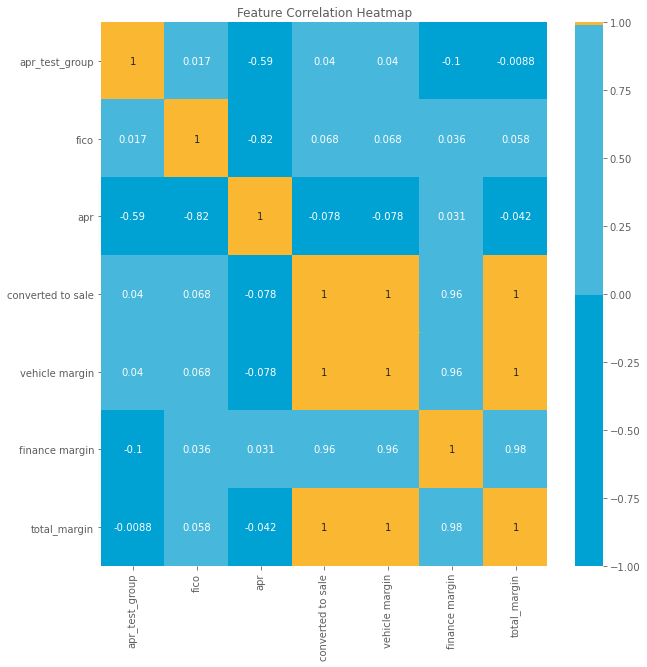

In [27]:
# heatmap of the correlation to visualize the relationships between features
plt.figure(figsize=(10,10))
plt.title('Feature Correlation Heatmap')
cmap = sns.color_palette(car_company_heatmap, 4)
sns.heatmap(hmap, annot = True, vmin=-1, vmax=1, cmap=cmap, center=1)

plt.show()

### Hypothesis Testing and Confidence Intervals

In [28]:
# subset df by A/B group
ab_test = car_company.groupby(['apr_test_group']).agg([np.mean, np.std, np.sum, 'count'])
ab_test = pd.DataFrame(ab_test.to_records())
ab_test = ab_test.drop(columns = ab_test.columns[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 20, 21, 22, 
                                                  24, 25, 26, 28]])
ab_test.columns = ['apr_test_group', 'conversion_rate', 'conversion_std', 'num_sales', 'total_apps',
                   'total_vehichle_margin', 'total_finance_margin', 'total_margin']
ab_test

,apr_test_group,conversion_rate,conversion_std,num_sales,total_apps,total_vehichle_margin,total_finance_margin,total_margin
0,control,0.23390879,0.42333598,2344,10021,2344000.0,1458600.0,3802600.0
1,test,0.26826335,0.44307765,2677,9979,2677000.0,995550.0,3672550.0


#### Hypothesis Test 1A) 
##### New APR on Total Margin - Welch's t-test

##### Null Hypothesis - H0: The total margin of the test group is less than or equal to the control group. 
##### Alternative Hypothesis - H1: The total margin of the test group is greater than the control group.

In [90]:
# subset df
control_margin = car_company[car_company['apr_test_group'] == 'control']['total_margin'].fillna(0)
test_margin = car_company[car_company['apr_test_group'] == 'test']['total_margin'].fillna(0)


In [93]:
# welch's t-test
t_stat, p_val = stats.ttest_ind(test_margin, control_margin, equal_var = False, alternative='greater')

print(f't-statistic :  {t_stat:.4f}')
print(f'p-value :   {p_val:.8f}')
print('\n')
if p_val < 0.05:
      print("Reject the null hypothesis")
else:
      print("Accept the null hypothesis")       

t-statistic :  -1.2468
p-value :   0.89375289


Accept the null hypothesis


##### With p=0.893 we accept the null hypothesis that the total margin of the test group is less than or equal to the control at alpha level = 0.05. 

#### Hypothesis Test 1B) 
##### New APR on Total Margin - Welch's t-test

##### Null Hypothesis - H0: The total margin of the test group is equal to the control group. 
##### Alternative Hypothesis - H1: The total margin of the test group is not equal to the control group.

In [94]:
# welch's t-test
t_stat, p_val = stats.ttest_ind(test_margin, control_margin, equal_var = False, alternative='two-sided')

print(f't-statistic :  {t_stat:.4f}')
print(f'p-value :   {p_val:.8f}')
print('\n')
if p_val < 0.05:
      print("Reject the null hypothesis")
else:
      print("Accept the null hypothesis")   

t-statistic :  -1.2468
p-value :   0.21249422


Accept the null hypothesis


##### With p=0.212 we accept the null hypothesis that the total margin or the test group is equal to the control at alpha level = 0.05. 

#### Hypothesis Test 2)
##### New APR on Conversion to Sales - Welch's t-test
##### Null Hypothesis - H0: Test conversion is less than or equal to the control conversion.
##### Alternative Hypothesis - H1: The test conversion is greater than the control conversion. 

In [40]:
# subset df
control_sale = car_company[car_company['apr_test_group'] == 'control']['converted to sale'].astype(int)
test_sale = car_company[car_company['apr_test_group'] == 'test']['converted to sale'].astype(int)

In [88]:
# welch's t-test
t_stat, p_val = stats.ttest_ind(test_sale, control_sale, equal_var = False, alternative='greater')

print(f't-statistic :  {t_stat:.4f}')
print(f'p-value :   {p_val:.8f}')
print('\n')
if p_val < 0.05:
      print("Reject the null hypothesis")
else:
      print("Accept the null hypothesis")


t-statistic :  5.6058
p-value :   0.00000001


Reject the null hypothesis


##### With p=0.00000001 we reject the null hypothesis and the difference in conversion is statistically signifigant at alpha level = 0.05

#### Effects Size of new APR on Conversion to Sale
##### Cohen's d

In [45]:
# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return (u1 - u2) / s

In [83]:
# calculate cohen's d
d = cohend(test_sale, control_sale)
print('Cohens d: %.3f' % d)
print('\n')
if d < 0.01:
      print("Very small effect size")
elif d < 0.2:
      print("Small effect size")
elif d < 0.5:
      print("Medium effect size")
elif d < 0.8:
      print("Large effect size")
elif d < 1.2:
      print("Very Large effect size")
else:
    print("Huge effect size")      


Cohens d: 0.079


Small effect size


##### There is a small effect of the new APR on the total margin

#### Confidence Intervals

In [99]:
# find confidence intervals for conversion rates per group
(lower_control, lower_test), (upper_control, upper_test) = proportion_confint(count=ab_test['num_sales'],
                                                                nobs=ab_test['total_apps'], alpha=0.05)
print(f'95% Confidence Interval for Control Group Conversion Rate: [{lower_control:.4f}, {upper_control:.4f}]')
print(f'95% Confidence Interval for Test Group Conversion Rate: [{lower_test:.4f}, {upper_test:.4f}]')

95% Confidence Interval for Control Group Conversion Rate: [0.2256, 0.2422]
95% Confidence Interval for Test Group Conversion Rate: [0.2596, 0.2770]


### 1) Car Company Pricing

##### What’s the current APR pricing strategy for the different FICO buckets? 
>######  The current strategy appears to be FICO scores of 600 have a 1.4 point higher APR than FICO scores of 700. 
##### How is the randomized test structured? 
>###### The test appears to be dropping the current APR down 1.0 point per FICO score.
>###### There is an almost even spread around 4900-5100 apps per subgroup. 
##### How do APR's vary by test group?
>###### The control APRs are 1.0 points higher than the test APRs.
>###### There is an increase in sales for both FICO score subgroups from the control to the test groups


In [34]:
# subset df
pricing = summary[['apr_test_group', 'fico', 'apr', 'total_apps', 'num_sales', 'num_no_sale']].copy()
pricing

,apr_test_group,fico,apr,total_apps,num_sales,num_no_sale
0,control,600,5.4,5095,1044,4051
1,control,700,4.0,4926,1300,3626
2,test,600,4.4,4906,1172,3734
3,test,700,3.0,5073,1505,3568


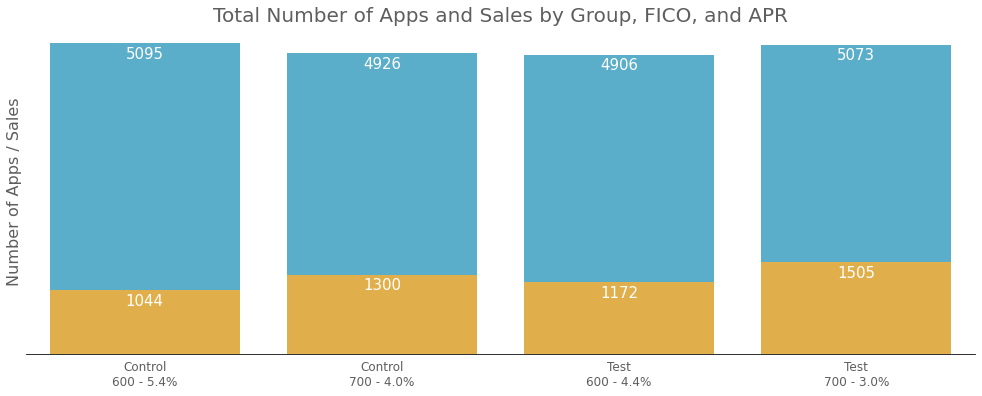

In [35]:
# plot apps and sales for each sub group

plt.figure(figsize=(17,6))

order = [5.4, 4.0, 4.4, 3.0]

apps = sns.barplot(data=pricing, x="apr", y="total_apps", order = order, color = car_company_lightblue)
sales = sns.barplot(data=pricing, x="apr", y="num_sales", order = order, color = car_company_gold)

plt.title("Total Number of Apps and Sales by Group, FICO, and APR", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylabel("Number of Apps / Sales", fontsize=16)
plt.xticks(ticks = range(4) ,labels = ['Control\n600 - 5.4%', 'Control\n700 - 4.0%', 'Test\n600 - 4.4%',
                                       'Test\n700 - 3.0%' ], size =12)
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=True)

for index, row in pricing[['num_sales']].iterrows():
    sales.text(row.name, row.num_sales-250, row.num_sales, color='white', ha="center", fontsize=15)

for index, row in pricing[['total_apps']].iterrows():
    apps.text(row.name, row.total_apps-250, row.total_apps, color='white', ha="center", fontsize=15)

plt.show()



### 2) Customer Conversion Rate

##### In general, how many applications is Car Company able to convert to a sale?  
>###### The conversion rate overall is approximately 25.105%
>###### There have been 5021 sales for 20000 applications.
##### How does that vary by FICO?
>###### The conversion rate for customers with a 600 FICO score is approximately 22.16%
>###### The conversion rate for customers with a 700 FICO score is approximately 28.05%
##### Using the APR test group data, how does the APR affect conversion?
>###### In general a decrease in APR leads to an increase in conversion rates. 
>###### This trend is persistent even within FICO and control/test groups.
>###### The conversion rate for customers in the control group is approximately 23.39%
>###### The conversion rate for customers in the test group is approximately 26.83%
>###### 95% Confidence Interval for Control Group Conversion Rate: [0.2256, 0.2422]
>###### 95% Confidence Interval for Test Group Conversion Rate: [0.2596, 0.2770]
>###### The conversion rate saw an increase of + 14.70 % from control to test groups.
>###### The conversion rate saw an increase of + 16.59 % for customers with a 600 FICO score.
>###### The conversion rate saw an increase of + 12.41 % for customers with a 700 FICO score.
>###### There was an increase in car sales by 128 for customers with a 600 FICO score. 
>###### There was an increase in car sales by 205 for customers with a 700 FICO score. 
>###### According to the Cohen's d value of 0.079 there is only a small effect size of APR on conversions to sale

In [36]:
# subset df
conversion = summary[['apr_test_group', 'fico', 'apr','conversion_rate', 'conversion_std', 'num_sales']].copy()
conversion

,apr_test_group,fico,apr,conversion_rate,conversion_std,num_sales
0,control,600,5.4,0.20490677,0.40367310,1044
1,control,700,4.0,0.26390581,0.44079357,1300
2,test,600,4.4,0.23889115,0.42644957,1172
3,test,700,3.0,0.29666864,0.45683421,1505


In [37]:
# subset df
group_conversion = ab_test[['apr_test_group','conversion_rate', 'conversion_std', 'num_sales']].copy()
group_conversion

,apr_test_group,conversion_rate,conversion_std,num_sales
0,control,0.23390879,0.42333598,2344
1,test,0.26826335,0.44307765,2677


In [38]:
# print conversion rates
print('The overall conversion rate is approximately' ,round(car_company['converted to sale'].mean() * 100, 3), '%')
print('The conversion rate for customers with a 600 FICO Score is approximately' ,
      round(car_company[car_company['fico'] == 600]['converted to sale'].mean() * 100, 2), '%')
print('The conversion rate for customers with a 700 FICO Score is approximately' ,
      round(car_company[car_company['fico'] == 700]['converted to sale'].mean() * 100, 2), '%')

The overall conversion rate is approximately 25.105 %
The conversion rate for customers with a 600 FICO Score is approximately 22.16 %
The conversion rate for customers with a 700 FICO Score is approximately 28.05 %


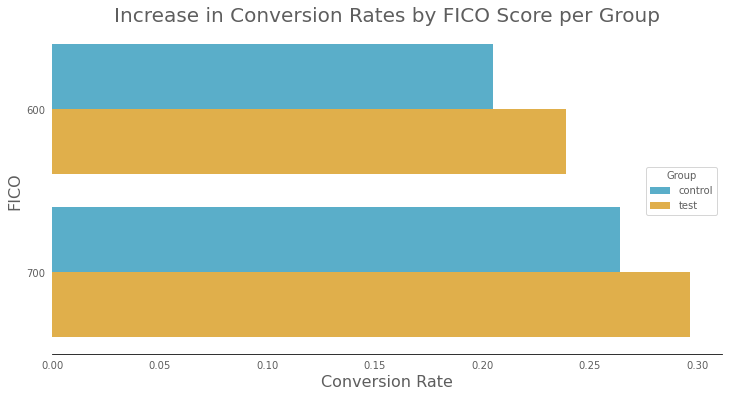

In [39]:
# plot increase in conversion rates
plt.figure(figsize=(12, 6))

sns.barplot(data = conversion, x = 'conversion_rate' , y = 'fico', hue='apr_test_group',
            palette = car_company_test_palette, orient = 'h')

plt.title("Increase in Conversion Rates by FICO Score per Group", fontsize=20)
plt.xlabel("Conversion Rate", fontsize=16)
plt.ylabel("FICO", fontsize=16)
plt.legend(loc='center right', title='Group')
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

plt.show()

In [40]:
# print increase in conversion rates
inc_600 =  round(((conversion[conversion['fico'] == 600]['conversion_rate'][2] / conversion[conversion['fico'] == 600]['conversion_rate'][0]) - 1 )* 100, 2)
inc_700 =  round(((conversion[conversion['fico'] == 700]['conversion_rate'][3] / conversion[conversion['fico'] == 700]['conversion_rate'][1]) - 1 )* 100, 2)
inc_group =  round(((group_conversion['conversion_rate'][1] / group_conversion['conversion_rate'][0]) - 1 )* 100, 2)

print('The conversion rate saw an increase of +', inc_600,'% for customers with a 600 FICO score')
print('The conversion rate saw an increase of +', inc_700,'% for customers with a 700 FICO score')
print('The conversion rate saw an increase of +', inc_group,'% for customers overall')

The conversion rate saw an increase of + 16.59 % for customers with a 600 FICO score
The conversion rate saw an increase of + 12.41 % for customers with a 700 FICO score
The conversion rate saw an increase of + 14.69 % for customers overall


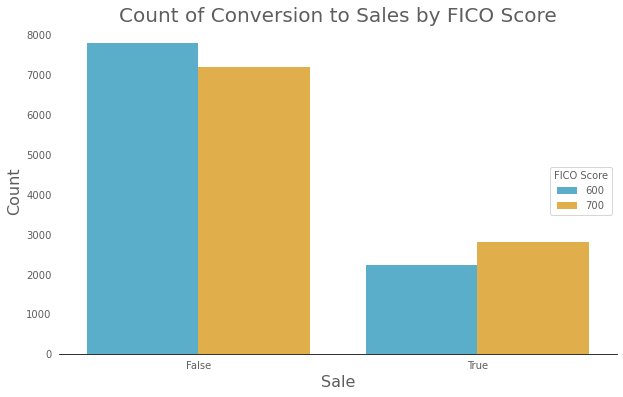

In [41]:
# plot counts of conversions for each fico bucket
plt.figure(figsize=(10, 6))

sns.countplot(data = car_company, x = 'converted to sale' , hue = 'fico', palette = car_company_fico_palette)

plt.title("Count of Conversion to Sales by FICO Score", fontsize=20)
plt.xlabel("Sale", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend(loc='center right', title='FICO Score')
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

plt.show()

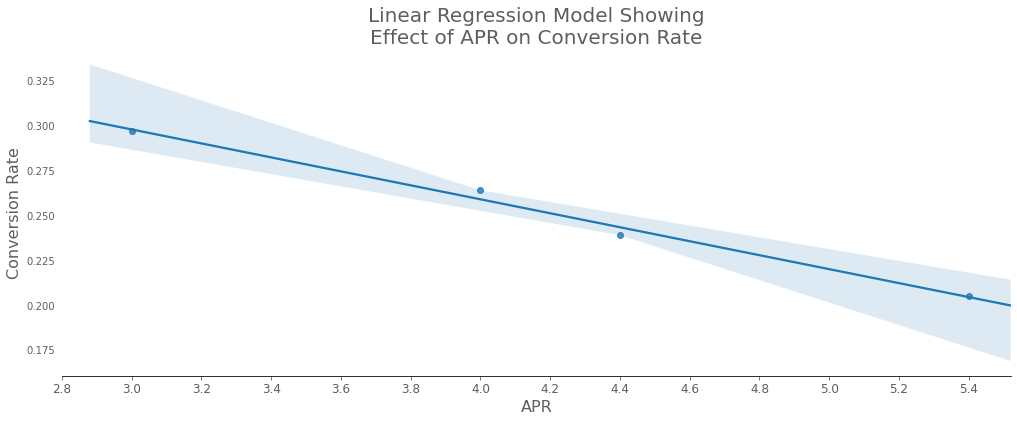

In [42]:
# plot lm for apr and conversion rates
plt.figure(figsize=(17,6))

sns.regplot(x='apr', y="conversion_rate", data=conversion, truncate = False)

plt.title("Linear Regression Model Showing\nEffect of APR on Conversion Rate", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Conversion Rate", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

plt.show()

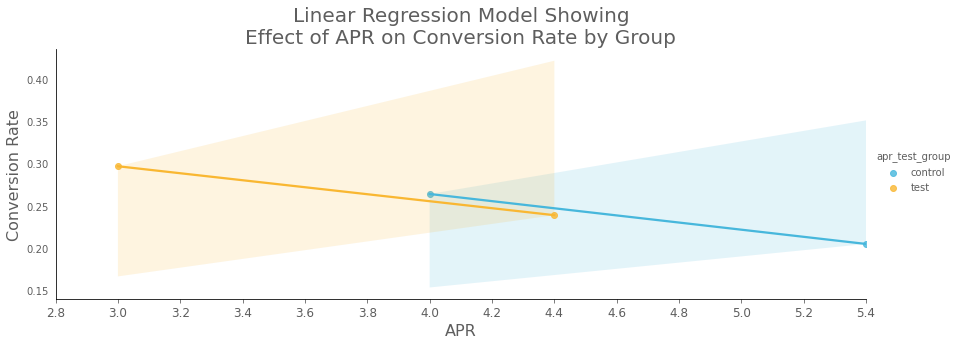

In [43]:
# plot lm for apr and conversion rates by test group
sns.lmplot(x='apr', y="conversion_rate", hue="apr_test_group", data=conversion, height = 4, aspect = 3, 
           palette = car_company_test_palette)

plt.title("Linear Regression Model Showing\nEffect of APR on Conversion Rate by Group", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Conversion Rate", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

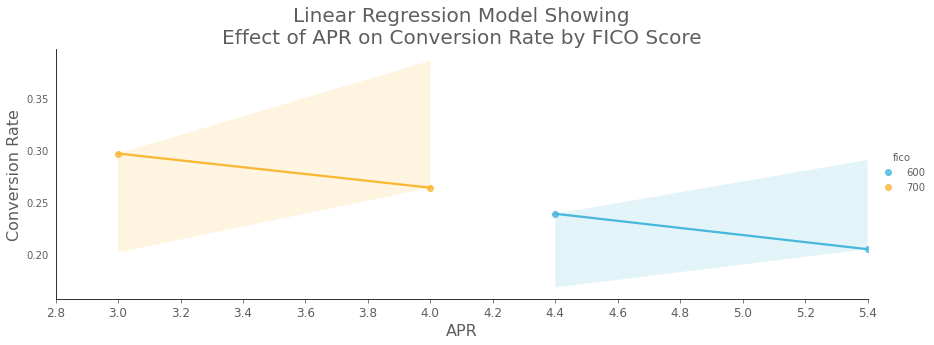

In [44]:
# plot lm for apr and conversion rates by fico score
sns.lmplot(x='apr', y="conversion_rate", hue="fico", data=conversion, height = 4, aspect = 3, 
           palette = car_company_fico_palette)

plt.title("Linear Regression Model Showing\nEffect of APR on Conversion Rate by FICO Score", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Conversion Rate", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

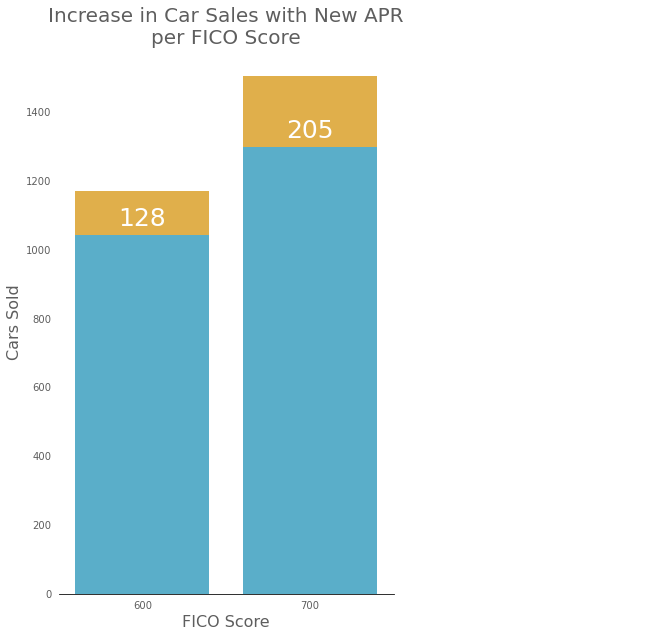

In [45]:
# plot increase in sales
plt.figure(figsize=(6, 10))
  

t_sales = sns.barplot(x=conversion[conversion['apr_test_group'] == 'test']['fico'], 
                      y=conversion[conversion['apr_test_group'] == 'test']['num_sales'], color=car_company_gold)
c_sales = sns.barplot(x=conversion[conversion['apr_test_group'] == 'control']['fico'], 
                      y=conversion[conversion['apr_test_group'] == 'control']['num_sales'], color=car_company_lightblue)
  
plt.title("Increase in Car Sales with New APR\nper FICO Score", fontsize=20)
plt.xlabel("FICO Score", fontsize=16)
plt.ylabel("Cars Sold", fontsize=16)
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

row_list = []
for index, row1 in conversion[conversion['apr_test_group'] == 'test'][['num_sales']].iterrows():
    t_sales.text(row1.name, row1.num_sales-50, row1.num_sales, color='white', ha="center", fontsize=15)
    row_list.append(row1[0])

for index, row in conversion[conversion['apr_test_group'] == 'control'][['num_sales']].iterrows():
    c_sales.text(row.name, row.num_sales+25, row_list[index]-row.num_sales, color='white', ha="center", fontsize=25)

plt.show()

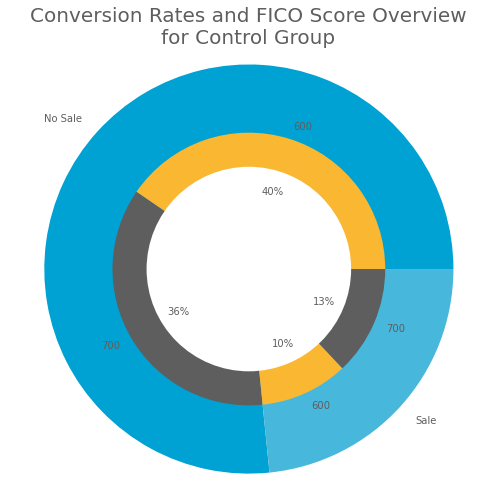

In [46]:
# plot control conversion rate overview
fig = plt.figure(figsize=(7, 7))

plt.title('Conversion Rates and FICO Score Overview\nfor Control Group', fontsize=20)

labels = ['No Sale','Sale']
sizes = control['converted to sale'].value_counts().tolist()

labels_pass = ['600', '700', '600', '700']

sizes_pass = np.concatenate([[control[(control['converted to sale']==False) & (control['fico']==600)].count().unique()[0]], 
        [control[(control['converted to sale']==False) & (control['fico']==700)].count().unique()[0]],
        control[(control['converted to sale']==True) & (control['fico']==600)].count().unique().tolist(), 
        control[(control['converted to sale']==True) & (control['fico']==700)].count().unique().tolist()])

colors = outer_list
colors_pass = inner_list


plt.pie(sizes, labels=labels, colors=colors, startangle=0, frame=True, radius=3)

plt.pie(sizes_pass, labels=labels_pass, colors=colors_pass, startangle=0, radius=2 ,autopct='%1.0f%%')

centre_circle = plt.Circle((0,0), 1.5, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')


plt.tight_layout()
plt.show()



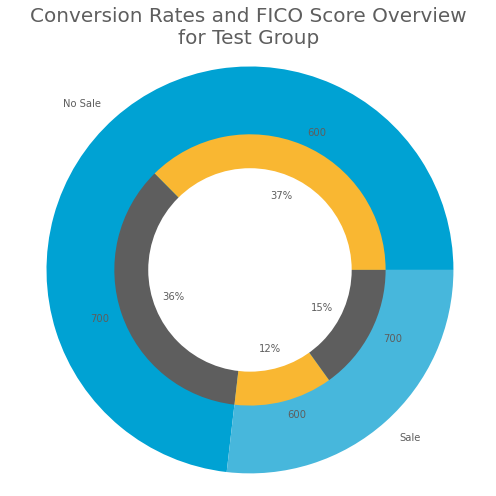

In [47]:
# plot test conversion rate overview
fig = plt.figure(figsize=(7, 7))

plt.title('Conversion Rates and FICO Score Overview\nfor Test Group', fontsize=20)

labels = ['No Sale','Sale']
sizes = test['converted to sale'].value_counts().tolist()

labels_pass = ['600', '700', '600', '700']

sizes_pass = np.concatenate([[test[(test['converted to sale']==False) & (test['fico']==600)].count().unique()[0]], 
        [test[(test['converted to sale']==False) & (test['fico']==700)].count().unique()[0]],
        test[(test['converted to sale']==True) & (test['fico']==600)].count().unique().tolist(), 
        test[(test['converted to sale']==True) & (test['fico']==700)].count().unique().tolist()])

colors = outer_list
colors_pass = inner_list


plt.pie(sizes, labels=labels, colors=colors, startangle=0, frame=True, radius=3)

plt.pie(sizes_pass, labels=labels_pass, colors=colors_pass, startangle=0, radius=2 ,autopct='%1.0f%%')

centre_circle = plt.Circle((0,0), 1.5, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.axis('equal')


plt.tight_layout()
plt.show()



### 3) Car Company Margin

##### What does Car Company make in margin overall (vehicle + financing), per sale and per application?  
>###### The total overall margin is approximately 7475150
>###### The total margin per sale is approximately 1488.78
>###### The total margin per app is approximately 373.76
##### How does APR affect the finance margin per sale?
>###### In general there is a negative trend in finance margin per sale for a decrease in APR. 
>###### This trend can be seen more clearly when looking at each FICO bucket seperately. 
>###### While there is a slight increase in vehicle margin per sale for an increase in APR, it is far outweighted by the inverse effect on the finance margin.
>###### The result is an overall decrease in total margin per sale for a decrease in APR. 
>###### For a drop of 1.0 point in APR there is a loss of \$250 in finance margin per sale.
>###### The same trends can be seen in margins per application.
##### How does FICO affect the finance margin per sale?
>###### The range of the finance margin per sale is higher for the 600 FICO customers than the 700 FICO customers.
>###### For both test and control groups the 600 FICO score customers both have a higher finance margin per sale than the 700 FICO customers, by \$50 each. 

 


In [48]:
# subset df
margin = summary[['apr_test_group', 'fico', 'apr','total_apps','num_sales','vehicle margin', 'finance margin', 
                  'total_margin', 'total_margin_per_sale','vehicle_margin_per_sale', 'finance_margin_per_sale',
                  'total_margin_per_app', 'vehicle_margin_per_app', 'finance_margin_per_app']].copy()
margin

,apr_test_group,fico,apr,total_apps,num_sales,vehicle margin,finance margin,total_margin,total_margin_per_sale,vehicle_margin_per_sale,finance_margin_per_sale,total_margin_per_app,vehicle_margin_per_app,finance_margin_per_app
0,control,600,5.4,5095,1044,1044000.0,678600.0,1722600.0,1650.0,1000.0,650.0,338.09617272,204.90677134,133.18940137
1,control,700,4.0,4926,1300,1300000.0,780000.0,2080000.0,1600.0,1000.0,600.0,422.24928948,263.90580593,158.34348356
2,test,600,4.4,4906,1172,1172000.0,468800.0,1640800.0,1400.0,1000.0,400.0,334.44761517,238.89115369,95.55646148
3,test,700,3.0,5073,1505,1505000.0,526750.0,2031750.0,1350.0,1000.0,350.0,400.50266115,296.66863789,103.83402326


In [49]:
# print margins
print('The total overall margin is approximately' ,round(margin['total_margin'].sum(), 2))
print('The total margin per sale is approximately' ,
      round(margin['total_margin'].sum() / margin['num_sales'].sum(), 2))
print('The total margin per app is approximately' ,
      round(margin['total_margin'].sum() / margin['total_apps'].sum(), 2))

The total overall margin is approximately 7475150.0
The total margin per sale is approximately 1488.78
The total margin per app is approximately 373.76


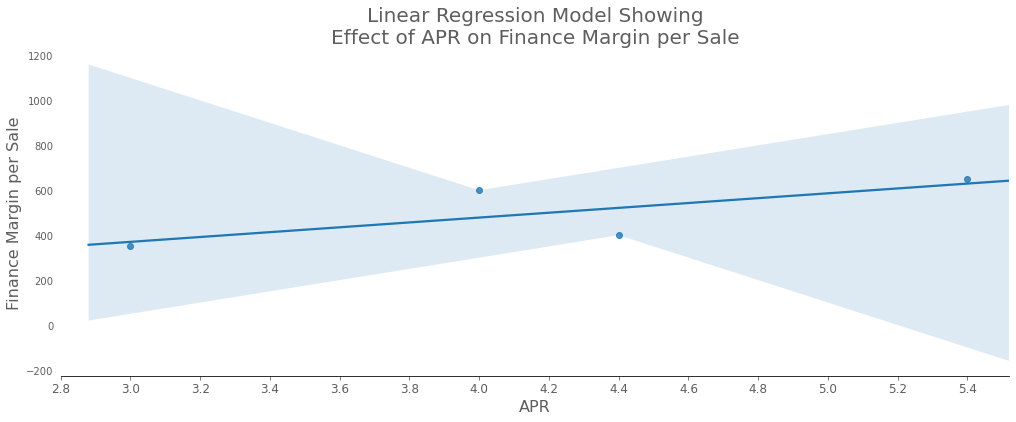

In [50]:
# plot lm trend of apr on finance margin per sale
plt.figure(figsize=(17,6))

sns.regplot(x='apr', y="finance_margin_per_sale", data=margin, truncate = False)

plt.title("Linear Regression Model Showing\nEffect of APR on Finance Margin per Sale", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Finance Margin per Sale", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

plt.show()

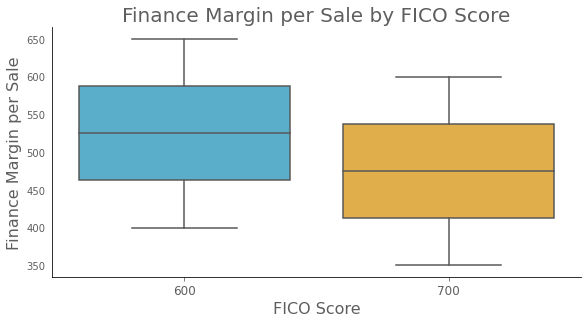

In [51]:
# plot range of finance margin per sale and fico
sns.catplot(y = "finance_margin_per_sale", x = "fico", kind = "box", data = margin, 
            palette = car_company_fico_palette, height=4, aspect=2)

plt.title("Finance Margin per Sale by FICO Score", fontsize=20)
plt.xlabel("FICO Score", fontsize=16)
plt.ylabel("Finance Margin per Sale", fontsize=16)
plt.xticks(size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

plt.show()


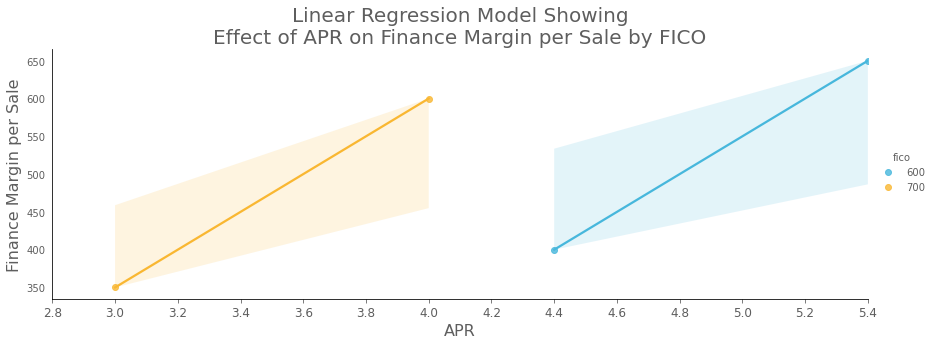

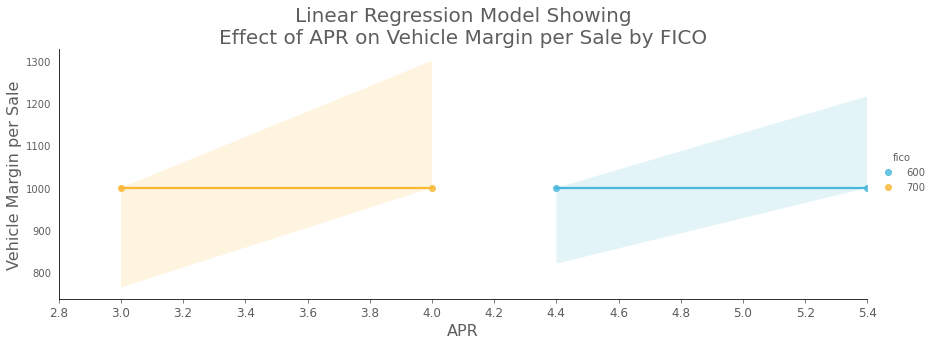

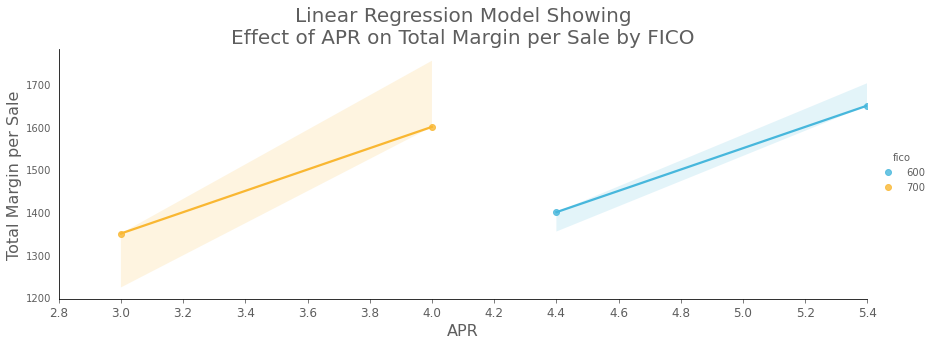

In [52]:
# lm plots for apr and finance margin per sale by fico
sns.lmplot(x='apr', y="finance_margin_per_sale", hue="fico", data=margin, height = 4, aspect = 3,
           palette = car_company_fico_palette, truncate = True)

plt.title("Linear Regression Model Showing\nEffect of APR on Finance Margin per Sale by FICO", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Finance Margin per Sale", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

sns.lmplot(x='apr', y="vehicle_margin_per_sale", hue="fico", data=margin, height = 4, aspect = 3, 
           palette = car_company_fico_palette, truncate = True)

plt.title("Linear Regression Model Showing\nEffect of APR on Vehicle Margin per Sale by FICO", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Vehicle Margin per Sale", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

sns.lmplot(x='apr', y="total_margin_per_sale", hue="fico", data=margin, height = 4, aspect = 3, 
           palette = car_company_fico_palette, truncate = True)

plt.title("Linear Regression Model Showing\nEffect of APR on Total Margin per Sale by FICO", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Total Margin per Sale", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

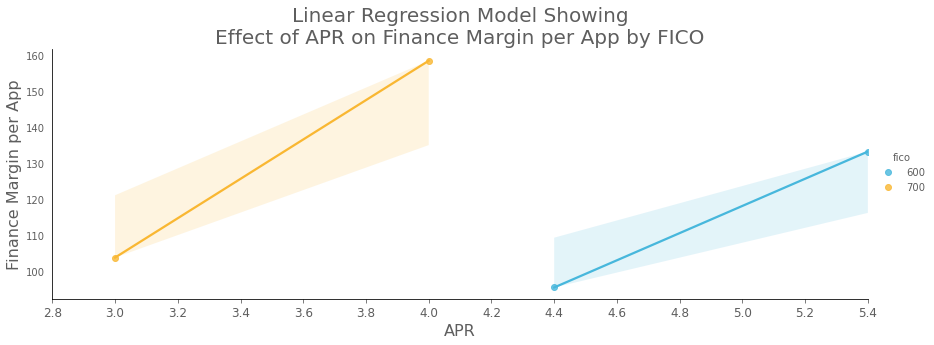

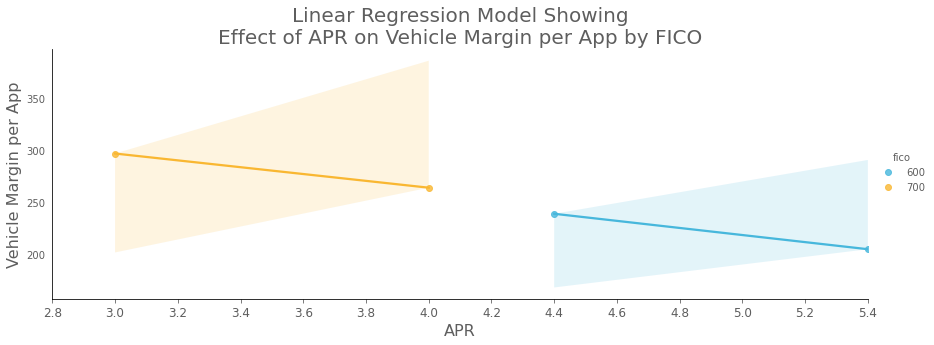

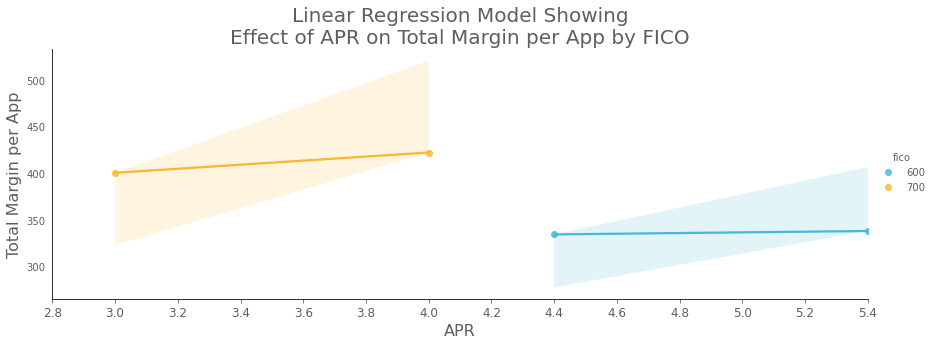

In [53]:
# lm plots for apr and finance margin per app by fico
sns.lmplot(x='apr', y="finance_margin_per_app", hue="fico", data=margin, height = 4, aspect = 3, 
           palette = car_company_fico_palette, truncate = True)

plt.title("Linear Regression Model Showing\nEffect of APR on Finance Margin per App by FICO", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Finance Margin per App", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

sns.lmplot(x='apr', y="vehicle_margin_per_app", hue="fico", data=margin, height = 4, aspect = 3, 
           palette = car_company_fico_palette, truncate = True)

plt.title("Linear Regression Model Showing\nEffect of APR on Vehicle Margin per App by FICO", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Vehicle Margin per App", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

sns.lmplot(x='apr', y="total_margin_per_app", hue="fico", data=margin, height = 4, aspect = 3, 
           palette = car_company_fico_palette, truncate = True)

plt.title("Linear Regression Model Showing\nEffect of APR on Total Margin per App by FICO", fontsize=20)
plt.xlabel("APR", fontsize=16)
plt.ylabel("Total Margin per App", fontsize=16)
plt.xticks(ticks = np.arange(2.8, 5.6, 0.2) , size =12)
plt.tick_params(left=False,bottom=True,labelleft=True,labelbottom=True)

### 4) Optimization of Rates

##### Using your understanding of conversion and total margin (across all applications) and how APR affects the two, 
##### if Car Company wants to optimize total margin, do you think Car Company should raise or lower rates on 700 FICO customers?
##### What about 600 FICO customers?
>###### Although a decrease in APR brought in a higher number of sales and drove up the conversion rates in both FICO buckets, 
>###### it unfortunately also lead to a decrease in total margin for both groups as well.
>###### The decrease is due to the lower finance margin per sale that comes along with the lesser APR. 
>###### The increase in vehicle margins was not enough to make up for this loss. 
>###### Both FICO groups saw a loss with the new decreased APR rate, although the 700 bucket had a much smaller loss. 
>###### Perhaps it is worth considering trying to increase the vehicle margin per sale in this 700 group to make up for the finance margin.
>###### It could also be looked at from a marketing perspective, and the increased attetion would be worth the total margin loss. 
>###### Although there was a loss it is importnat to note that according to Hypothesis Test 1B there is not a statistically signifigant difference in the total margin between groups at an alpha level of 0.05. 
>###### car_company could also repeat this A/B test, but in the other direction, raising the APR rates for each FICO group. 
>###### Regression does show an increase in total margin for an increased APR rate in both groups but there is no guarantee the relationship is linear. 
>###### Either way it would be my recommendation to at least revert back to the control group's APR rates for both FICO buckets until we have more information. 
>###### I will show here projections of what an increase in APR might look like on the margins.

In [54]:
# subset df
big_picture = summary[['apr_test_group', 'fico', 'apr' , 'total_margin', 'vehicle margin', 
                       'finance margin', 'total_margin_per_app']].copy()
big_picture

,apr_test_group,fico,apr,total_margin,vehicle margin,finance margin,total_margin_per_app
0,control,600,5.4,1722600.0,1044000.0,678600.0,338.09617272
1,control,700,4.0,2080000.0,1300000.0,780000.0,422.24928948
2,test,600,4.4,1640800.0,1172000.0,468800.0,334.44761517
3,test,700,3.0,2031750.0,1505000.0,526750.0,400.50266115


In [55]:
# get data ready to graph
big_picture_600 = big_picture[big_picture['fico']==600]
bars1 = list(big_picture_600['total_margin'])
bars2 = list(big_picture_600['vehicle margin'])
bars3 = list(big_picture_600['finance margin'])
bars = (bars1 + bars2 + bars3)
names = ['Total Margin\nControl', 'Total Margin\nTest', 'Vehicle Margin\nControl', 'Vehicle Margin\nTest',
         'Finance Margin\nControl', 'Finance Margin\nTest']
big_600 = pd.DataFrame(zip(bars, names), columns =['bars', 'names'])

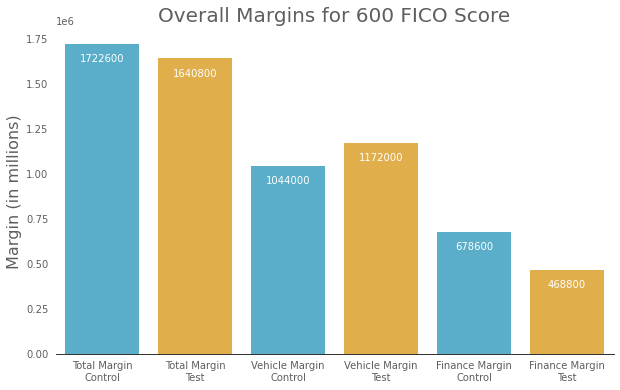

In [56]:
# plot total margins for 600 fico group
plt.figure(figsize=(10, 6))

b6 = sns.barplot(data= big_600, x='names', y = 'bars',palette = car_company_list, dodge=False)

plt.title("Overall Margins for 600 FICO Score", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylabel("Margin (in millions)", fontsize=16)
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

for index, row in big_600[['bars']].iterrows():
    b6.text(row.name, row.bars-100000, round(row.bars), color='white', ha="center", fontsize=10)

plt.show()

In [57]:
# get data ready to graph
big_picture_700 = big_picture[big_picture['fico']==700]
bars1 = list(big_picture_700['total_margin'])
bars2 = list(big_picture_700['vehicle margin'])
bars3 = list(big_picture_700['finance margin'])
bars = (bars1 + bars2 + bars3)
names = ['Total Margin\nControl', 'Total Margin\nTest', 'Vehicle Margin\nControl', 'Vehicle Margin\nTest',
         'Finance Margin\nControl', 'Finance Margin\nTest']
big_700 = pd.DataFrame(zip(bars, names), columns =['bars', 'names'])


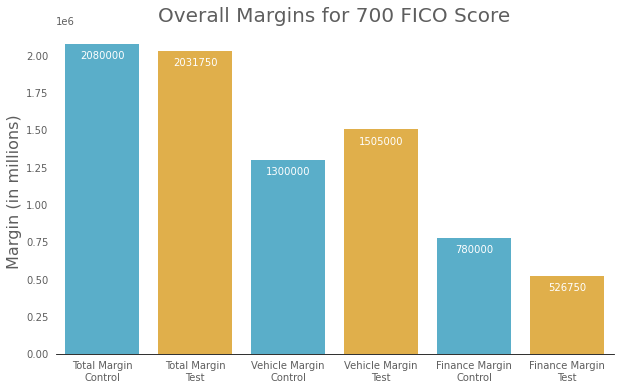

In [58]:
# plot total margins for 600 fico group
plt.figure(figsize=(10, 6))

b7 = sns.barplot(data= big_700, x='names', y = 'bars',palette = car_company_list, dodge=False)

plt.title("Overall Margins for 700 FICO Score", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylabel("Margin (in millions)", fontsize=16)
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

for index, row in big_700[['bars']].iterrows():
    b7.text(row.name, row.bars-100000, round(row.bars), color='white', ha="center", fontsize=10)

plt.show()

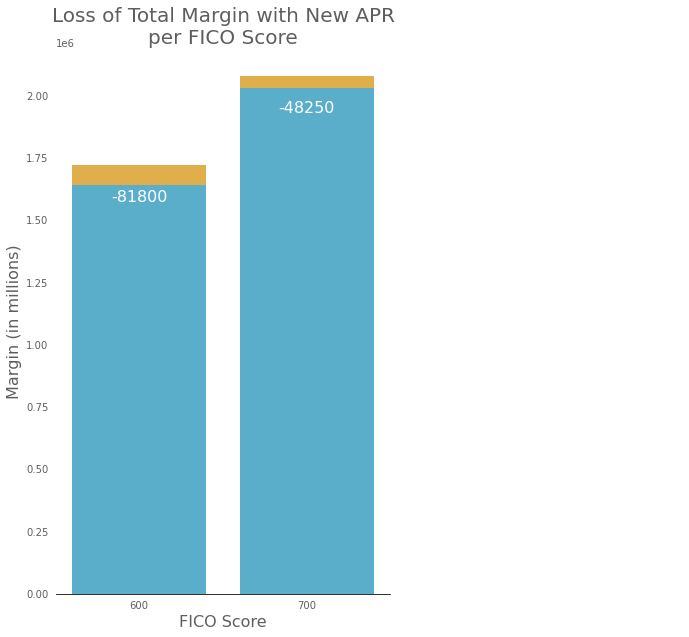

In [59]:
# plot loss for new apr
plt.figure(figsize=(6, 10))
  
loss_control = sns.barplot(x=big_picture[big_picture['apr_test_group'] == 'control']['fico'], 
                           y=big_picture[big_picture['apr_test_group'] == 'control']['total_margin'], color=car_company_gold)
loss_test = sns.barplot(x=big_picture[big_picture['apr_test_group'] == 'test']['fico'], 
                        y=big_picture[big_picture['apr_test_group'] == 'test']['total_margin'],color=car_company_lightblue)
  
plt.title("Loss of Total Margin with New APR\nper FICO Score", fontsize=20)
plt.xlabel("FICO Score", fontsize=16)
plt.ylabel("Margin (in millions)", fontsize=16)
plt.tick_params(left=False,bottom=False,labelleft=True,labelbottom=True)

row_list = []
for index, row1 in big_picture[big_picture['apr_test_group'] == 'test'][['total_margin']].iterrows():
    loss_test.text(row1.name, row1.total_margin-50, row1.total_margin, color='white', ha="center", fontsize=15)
    row_list.append(row1[0])

for index, row in big_picture[big_picture['apr_test_group'] == 'control'][['total_margin']].iterrows():
    loss_control.text(row.name, row.total_margin-150000, round(row_list[index]-row.total_margin), 
                      color='white', ha="center", fontsize=16)

plt.show()

In [60]:
# subset df
projection = big_picture[['apr_test_group', 'fico', 'apr' , 'total_margin_per_app']].copy()
projection

,apr_test_group,fico,apr,total_margin_per_app
0,control,600,5.4,338.09617272
1,control,700,4.0,422.24928948
2,test,600,4.4,334.44761517
3,test,700,3.0,400.50266115


In [61]:
# regression on fico 600
lr_600 = LinearRegression()

x = projection[projection['fico']==600][['apr']]
y = projection[projection['fico']==600][['total_margin_per_app']]

lr_600.fit(x, y)

print('Intercept: ', lr_600.intercept_)
print('Coefficients: ', lr_600.coef_)

rate_600 = 6.4
pred_600 = round(lr_600.predict([[rate_600]])[0][0], 2)

print (f'Predicted Total Margin Per App for a Customer with 600 FICO Score and an APR of {rate_600} is approximately: {pred_600}')

Intercept:  [318.39396193]
Coefficients:  [[3.64855755]]
Predicted Total Margin Per App for a Customer with 600 FICO Score and an APR of 6.4 is approximately: 341.74


In [62]:
# regression on fico 700
lr_700 = LinearRegression()

x = projection[projection['fico']==700][['apr']]
y = projection[projection['fico']==700][['total_margin_per_app']]

lr_700.fit(x, y)

print('Intercept: ', lr_700.intercept_)
print('Coefficients: ', lr_700.coef_)

rate_700 = 5.0
pred_700 = round(lr_700.predict([[rate_700]])[0][0], 2)

print (f'Predicted Total Margin Per App for a Customer with 700 FICO Score and an APR of {rate_700} is approximately: {pred_700}')

Intercept:  [335.26277614]
Coefficients:  [[21.74662834]]
Predicted Total Margin Per App for a Customer with 700 FICO Score and an APR of 5.0 is approximately: 444.0


In [63]:
#append rows to the dataframe
row1 = {'apr_test_group':'projected', 'fico':600, 'apr':rate_600, 'total_margin_per_app':pred_600}
row2 = {'apr_test_group':'projected', 'fico':700, 'apr':rate_700, 'total_margin_per_app':pred_700}

projection = projection.append(row1, ignore_index=True).append(row2, ignore_index=True)
projection['margin_for_5000_customers'] = projection['total_margin_per_app'] * 5000
projection = projection.sort_values(['fico', 'apr'],ascending = [True, False]).reset_index()
projection

,index,apr_test_group,fico,apr,total_margin_per_app,margin_for_5000_customers
0,4,projected,600,6.4,341.74000000,1.70870000e+06
1,0,control,600,5.4,338.09617272,1.69048086e+06
2,2,test,600,4.4,334.44761517,1.67223808e+06
3,5,projected,700,5.0,444.00000000,2.22000000e+06
4,1,control,700,4.0,422.24928948,2.11124645e+06
5,3,test,700,3.0,400.50266115,2.00251331e+06


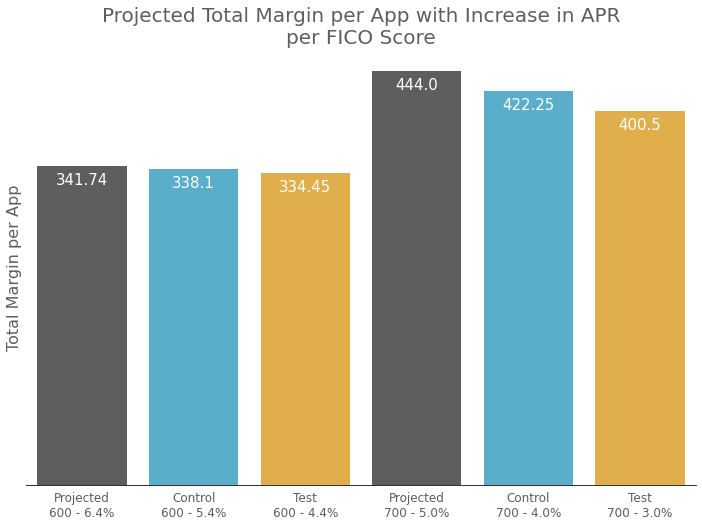

In [64]:
# plot projected margin per app
plt.figure(figsize=(12,8))

order = [6.4, 5.4, 4.4, 5.0, 4.0, 3.0]
labels = ['Projected\n600 - 6.4%','Control\n600 - 5.4%', 'Test\n600 - 4.4%', 'Projected\n700 - 5.0%', 
          'Control\n700 - 4.0%','Test\n700 - 3.0%' ]

proj = sns.barplot(data=projection, x="apr", y="total_margin_per_app", order = order, palette = car_company_apr_palette)

plt.title("Projected Total Margin per App with Increase in APR\nper FICO Score", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylabel("Total Margin per App", fontsize=16)
plt.xticks(ticks = range(6) ,labels = labels, size =12)
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=True)

for index, row in projection[['total_margin_per_app']].iterrows():
    proj.text(row.name, row.total_margin_per_app-20, round(row.total_margin_per_app, 2), color='white', 
              ha="center", fontsize=15)


plt.show()

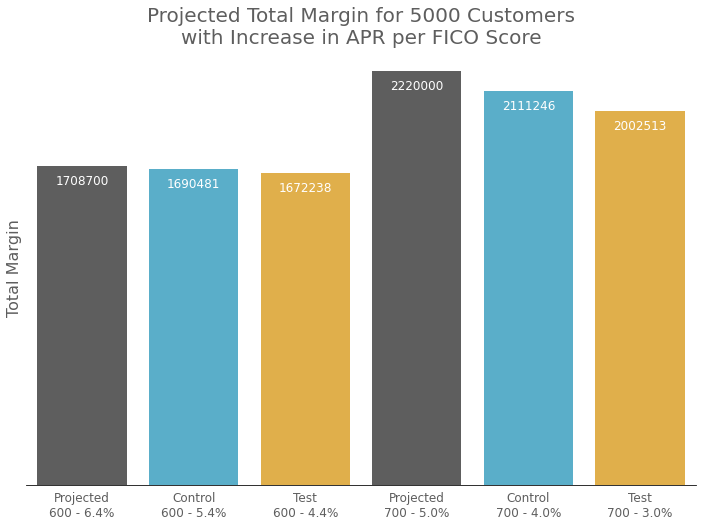

In [65]:
# plot projected margin overall
plt.figure(figsize=(12,8))

order = [6.4, 5.4, 4.4, 5.0, 4.0, 3.0]
labels = ['Projected\n600 - 6.4%','Control\n600 - 5.4%', 'Test\n600 - 4.4%', 'Projected\n700 - 5.0%',
          'Control\n700 - 4.0%','Test\n700 - 3.0%' ]

proj = sns.barplot(data=projection, x="apr", y="margin_for_5000_customers", order = order, 
                   palette = car_company_apr_palette)

plt.title("Projected Total Margin for 5000 Customers\nwith Increase in APR per FICO Score", fontsize=20)
plt.xlabel("", fontsize=16)
plt.ylabel("Total Margin", fontsize=16)
plt.xticks(ticks = range(6) ,labels = labels, size =12)
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=True)

for index, row in projection[['margin_for_5000_customers']].iterrows():
    proj.text(row.name, row.margin_for_5000_customers-100000, round(row.margin_for_5000_customers), 
              color='white', ha="center", fontsize=12)


plt.show()

### 5) Other Factors

##### Other than these cut and dry numbers, can you think of other factors Car Company might want to take into account before changing rates? 
>###### Ideally, Car Company could conduct more tests to adjust FICO and APR scores. It was hard to predict the relationships between factors with only two FICO scores. 
>###### The linear regression models project increased revenue with increased APR rates, especially in the 700 FICO score group,
>###### but presumably there is a ceiling to what consumers will tolerate before they change their buying behavior. 
>###### Variability in vehicle margin (compared to the flat rate in this data set) could also have a significant impact on the total margin,
>###### and result in a different FICO/APR recommendation.
>###### It is worth exploring the value of other variables that come into play with increased conversion rate, including increased customers and customer satisfaction.
>###### More customers could bring in additional customers through word of mouth, as more people share their positive experiences with car_company.
>###### More sales could theoretically also have a detrimental impact on budget through increased costs, such as shipping costs.
>###### Profit is also greatly impacted by the finance margin. Perhaps it would be worth considering whether increased sales from lower APR rates could incentivize 
>###### the loan purchaser(s) to re-negotiate and purchase loans for a higher price, since they would be guaranteed more sales.
>###### Generally speaking, having more factors and variability in factors could lead to better predictive models,
>###### and would open the door for the use of other models like deep learning, simulation, and optimization. 
>###### This would result in more accurate insights and improved profit margin.